# **Proyecto 2 - Entrega 6

## 👥 **Integrantes:**  
- **Diederich Solis** (22952)  
- **Gabriel Paz** (221087)  

---

## **Uso del conjunto de datos de entrenamiento y prueba**

En esta sección se utiliza el mismo conjunto de datos `train.csv` empleado en entregas anteriores. La separación de datos en entrenamiento y prueba se mantiene constante para garantizar la validez de las comparaciones entre modelos.

Se cargan los datos utilizando `pandas` y se verifica su correcta estructura para preparar el preprocesamiento necesario para los modelos SVM.


In [5]:
# Librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Cargar el dataset
data = pd.read_csv('train.csv')

# Mostrar primeras filas
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## **Exploración y Transformación de Datos**

Se realiza un análisis exploratorio inicial para comprender la estructura del dataset, identificar valores faltantes y analizar las variables relevantes.  
Posteriormente, se aplican transformaciones necesarias como imputación de datos, codificación de variables categóricas y escalado de variables numéricas para preparar el dataset para su uso en modelos de Máquinas de Vectores de Soporte (SVM).


In [6]:
# Información general del dataset
data.info()

# Verificar valores nulos
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

# Rellenar valores nulos para simplicidad (puedes cambiar si quieres ser más sofisticado)
data = data.fillna(data.median(numeric_only=True))

# Eliminar columnas no numéricas o altamente categóricas para este experimento
data = data.select_dtypes(include=[np.number])

# Confirmar limpieza
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## **Creación de la variable categórica de precios (Barata, Media, Cara)**

Se genera una variable categórica basada en el valor de `SalePrice` para clasificar las propiedades en "baratas", "medias" y "caras" usando los percentiles 33% y 66% como umbrales de segmentación.


PrecioCategoria
Caro      0.340411
Barato    0.330822
Medio     0.328767
Name: proportion, dtype: float64


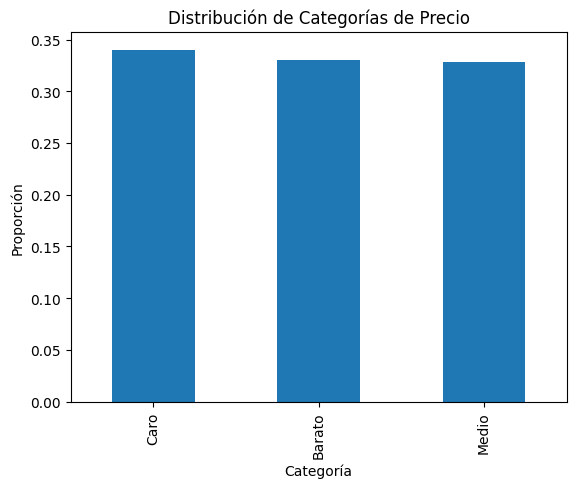

In [12]:
# Crear variable categórica
percentiles = np.percentile(data['SalePrice'], [33, 66])

def categorizar_precio(precio):
    if precio <= percentiles[0]:
        return 'Barato'
    elif precio <= percentiles[1]:
        return 'Medio'
    else:
        return 'Caro'

data['PrecioCategoria'] = data['SalePrice'].apply(categorizar_precio)

# Visualización del balance de clases
balance = data['PrecioCategoria'].value_counts(normalize=True)
print(balance)

balance.plot(kind='bar', title='Distribución de Categorías de Precio')
plt.xlabel('Categoría')
plt.ylabel('Proporción')
plt.show()



## **Creación de Modelos SVM con diferentes kernels y parámetros**

Se crean múltiples modelos SVM utilizando diferentes configuraciones de kernels: `lineal`, `rbf` (gaussiano) y `polinomial`.  
Se ajustan también hiperparámetros como `C`, `gamma` y `degree` para explorar su impacto en el desempeño del modelo.


In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Variables predictoras y respuesta
X = data.drop(columns=['SalePrice', 'PrecioCategoria'])
y = data['PrecioCategoria']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Partición
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Definimos modelos básicos
models = {
    "SVM Lineal": SVC(kernel='linear'),
    "SVM RBF": SVC(kernel='rbf'),
    "SVM Polinomial": SVC(kernel='poly')
}

# Hiperparámetros a buscar
param_grid = {
    'linear': {'C': [0.1, 1, 10]},
    'rbf': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]},
    'poly': {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
}

# GridSearchCV
best_models = {}
for name, model in models.items():
    if model.kernel == 'linear':
        grid = GridSearchCV(model, param_grid['linear'], cv=5, n_jobs=-1)
    elif model.kernel == 'rbf':
        grid = GridSearchCV(model, param_grid['rbf'], cv=5, n_jobs=-1)
    else:  # polinomial
        grid = GridSearchCV(model, param_grid['poly'], cv=5, n_jobs=-1)

    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

# Mostrar mejores hiperparámetros
for name, model in best_models.items():
    print(f"Mejor modelo {name}: {model}")


Mejor modelo SVM Lineal: SVC(C=0.1, kernel='linear')
Mejor modelo SVM RBF: SVC(C=1, gamma=0.01)
Mejor modelo SVM Polinomial: SVC(C=10, kernel='poly')


## **Predicción de la Variable Respuesta con los Modelos SVM**

Se realizan las predicciones en el conjunto de prueba para evaluar el desempeño de cada modelo SVM utilizando diferentes configuraciones de kernel.


In [9]:
# Predicciones
y_pred_linear = svm_linear.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)
y_pred_poly = svm_poly.predict(X_test)


## **Evaluación: Matrices de Confusión**

Se presentan las matrices de confusión para los diferentes modelos SVM creados.  
Estas matrices permiten visualizar el desempeño del modelo en términos de predicciones correctas e incorrectas en cada clase.


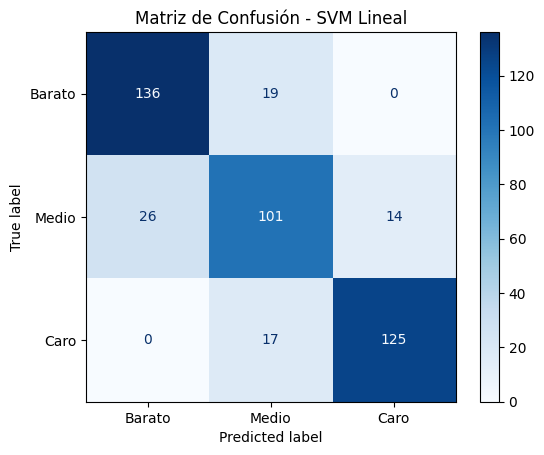

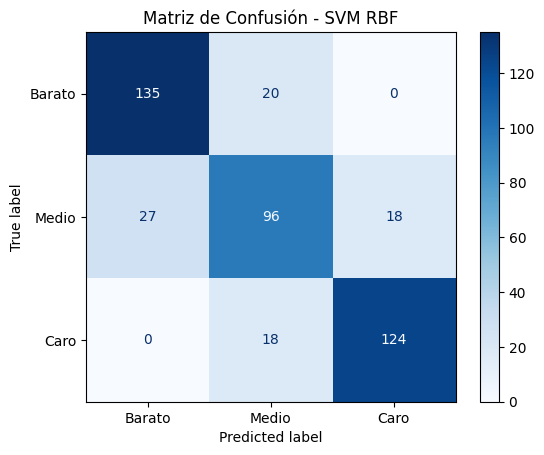

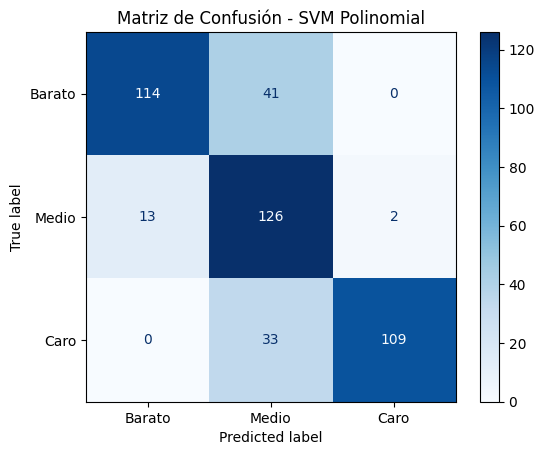

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Función para graficar matrices
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['Barato', 'Medio', 'Caro'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Barato', 'Medio', 'Caro'])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

import matplotlib.pyplot as plt

# Mostrar matrices
plot_confusion(y_test, y_pred_linear, 'Matriz de Confusión - SVM Lineal')
plot_confusion(y_test, y_pred_rbf, 'Matriz de Confusión - SVM RBF')
plot_confusion(y_test, y_pred_poly, 'Matriz de Confusión - SVM Polinomial')


## **Análisis de Sobreajuste o Subajuste**

Se analiza el posible sobreajuste (overfitting) o subajuste (underfitting) de los modelos generados observando su desempeño en entrenamiento y prueba.  
Además, se discuten estrategias de ajuste de hiperparámetros para mejorar el balance entre sesgo y varianza de los modelos.


In [19]:
# Scores
for name, model in best_models.items():
    print(f"{name} - Train Score: {model.score(X_train, y_train):.4f}, Test Score: {model.score(X_test, y_test):.4f}")


SVM Lineal - Train Score: 0.8630, Test Score: 0.8151
SVM RBF - Train Score: 0.8796, Test Score: 0.8105
SVM Polinomial - Train Score: 0.9746, Test Score: 0.8059
